# Formula One Project: Modeling

DUE: December 4th, 2024 (Wed)  
Name(s): Sean O'Connor, Connor Coles    
Class: CSCI 349 - Intro to Data Mining  
Semester: Fall 2024  
Instructor: Brian King  

## Assignment Description

Copy over the important cells from the previous step that read in and cleaned your data to this new notebook file. You do not need to copy over all your EDA and plots describing your data, only the code that prepares your data for modeling. This notebook is about exploring the development of predictive models. Some initial preliminary work on applying some modeling techniques should be completed.
Be sure to commit and push all supporting code that you've completed in this file. Include in this notebook a summary cell at the top that details your accomplishments, challenges, and what you expect to accomplish for your final steps. Be sure to update your readme.md in your repository.

In [3]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import fastf1
import fastf1.plotting
from fastf1.ergast.structure import FastestLap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [18]:
# FastF1 general setup
cache_dir = '../data/cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme=None)

# Set up plot style
# print style.available to check available styles
print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [5]:
# Define years, sessions, and events of interest
years = [2021, 2022, 2023, 2024]
sessions = ['Race']
events = ['Bahrain Grand Prix', 'British Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix', 'São Paulo Grand Prix'] 

In [6]:
# Get data from FastF1 API

# Data containers
weather_data_list = []
lap_data_list = []

# Loop through years and sessions
for year in years:
    for event_name in events:   
        for session_name in sessions:
            try:
                print(f"Processing {year} {event_name} - {session_name}")
                
                # Load the session
                session = fastf1.get_session(year, event_name, session_name, backend='fastf1')
                session.load()
                
                # Process weather data
                weather_data = session.weather_data
                if weather_data is not None:
                    weather_df = pd.DataFrame(weather_data)
                    # Add context columns
                    weather_df['Year'] = year
                    weather_df['Event'] = event_name
                    weather_df['Session'] = session_name
                    weather_data_list.append(weather_df)

                # Process lap data
                lap_data = session.laps
                if lap_data is not None:
                    lap_df = pd.DataFrame(lap_data)
                    # Add context columns
                    lap_df['Year'] = year
                    lap_df['Event'] = event_name
                    lap_df['Session'] = session_name
                    # Ensure driver information is included
                    if 'Driver' not in lap_df.columns:
                        lap_df['Driver'] = lap_df['DriverNumber'].map(session.drivers)
                    # Add team information if available
                    if 'Team' not in lap_df.columns:
                        lap_df['Team'] = lap_df['Driver'].map(session.drivers_info['TeamName'])
                    lap_data_list.append(lap_df)
        
            except Exception as e:
                print(f"Error with {event_name} {session_name} ({year}): {e}")

# Combine data into DataFrames
if weather_data_list:
    weather_data_combined = pd.concat(weather_data_list, ignore_index=True)
    # Ensure consistent column ordering
    weather_cols = ['Time', 'Year', 'Event', 'Session', 
                   'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
                   'TrackTemp', 'WindDirection', 'WindSpeed']
    weather_data_combined = weather_data_combined[weather_cols]
    
if lap_data_list:
    lap_data_combined = pd.concat(lap_data_list, ignore_index=True)
    # Ensure consistent column ordering
    lap_cols = ['Time', 'Year', 'Event', 'Session', 
                'Driver', 'Team', 'LapNumber', 'LapTime',
                'Sector1Time', 'Sector2Time', 'Sector3Time',
                'Compound', 'TyreLife', 'FreshTyre',
                'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
    # Only include columns that exist
    existing_cols = [col for col in lap_cols if col in lap_data_combined.columns]
    lap_data_combined = lap_data_combined[existing_cols]
    
# Time conversion
# Function to convert timedelta to datetime
def convert_timedelta_to_datetime(df, base_date='2021-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Apply conversion to both dataframes
weather_data_combined = convert_timedelta_to_datetime(weather_data_combined)
lap_data_combined = convert_timedelta_to_datetime(lap_data_combined)

# Remove missing values
weather_data_combined = weather_data_combined.dropna()
lap_data_combined = lap_data_combined.dropna()

# Create a new column for lap time in seconds
lap_data_combined['LapTime_seconds'] = lap_data_combined['LapTime'].dt.total_seconds()

# Merge the data
merged_data = pd.merge_asof(
    lap_data_combined.sort_values('Time'),
    weather_data_combined.sort_values('Time'),
    on='Time',
    by=['Event', 'Year'],  # Match within same event and year
    direction='nearest',
    tolerance=pd.Timedelta('1 min')  # Allow matching within 1 minute
)

Processing 2021 Bahrain Grand Prix - Race


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '6', '14', '9']
core           INFO 	Loading data for British Grand Prix - Race 

Processing 2021 British Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '16', '77', '4', '3', '55', '14', '18', '31', '22', '10', '63', '99', '6', '7', '11', '9', '47', '5', '33']
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2021 United States Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  7: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '16', '3', '77', '55', '4', '22', '5', '99', '18', '7', '63', '6', '47', '9', '14', '31', '10']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached da

Processing 2021 Mexico City Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '10', '16', '55', '5', '7', '14', '4', '99', '3', '31', '18', '77', '63', '6', '9', '47', '22']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2021 São Paulo Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '16', '55', '10', '31', '14', '4', '5', '7', '63', '99', '22', '6', '9', '47', '3', '18']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2022 Bahrain Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2022 British Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req         

Processing 2022 United States Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '11', '63', '4', '14', '5', '20', '22', '31', '24', '23', '10', '47', '3', '6', '18', '77', '55']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2022 Mexico City Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '11', '63', '55', '16', '3', '31', '4', '77', '10', '23', '24', '5', '18', '47', '20', '6', '14', '22']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2022 São Paulo Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '55', '16', '14', '1', '11', '31', '77', '18', '5', '24', '47', '10', '23', '6', '22', '4', '20', '3']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2023 Bahrain Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2023 British Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req       

Processing 2023 United States Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '14', '81', '31', '44', '16']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2023 Mexico City Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '55', '4', '63', '3', '81', '23', '31', '10', '22', '27', '24', '77', '2', '18', '14', '20', '11']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2023 São Paulo Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '14', '11', '18', '55', '10', '44', '22', '31', '2', '27', '3', '81', '63', '77', '24', '20', '23', '16']


Processing 2024 Bahrain Grand Prix - Race


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for British Grand Prix - Rac

Processing 2024 British Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req        

Processing 2024 United States Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '4', '81', '63', '11', '27', '30', '43', '20', '10', '14', '22', '18', '23', '77', '31', '24', '44']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2024 Mexico City Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2024 São Paulo Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16', '4', '22', '81', '30', '44', '11', '50', '77', '14', '24', '55', '43', '23', '18', '27']


In [7]:
# Feature Engineering
def engineer_features(df):
    # Normalize lap times per track
    df['NormalizedLapTime'] = df.groupby('Event')['LapTime_seconds'].transform(
        lambda x: (x - x.mean()) / x.mean()
    )
    
    # Driver performance metrics (now track-specific)
    df['DriverTrackAvg'] = df.groupby(['Driver', 'Event'])['LapTime_seconds'].transform('mean')
    df['DriverTrackStd'] = df.groupby(['Driver', 'Event'])['LapTime_seconds'].transform('std')
    
    # Calculate driver's performance relative to track average
    df['DriverTrackPerformance'] = df.groupby(['Event', 'Year'])['LapTime_seconds'].transform(
        lambda x: (x - x.mean()) / x.mean()
    )
    
    # Tire performance degradation (exponential, track-specific)
    # Different tracks have different tire wear characteristics
    df['TyreAgeFactor'] = df.groupby('Event')['TyreLife'].transform(
        lambda x: np.exp(-0.02 * x)  # Could vary coefficient by track type
    )
    
    # Track evolution (grip improvement, track-specific)
    df['TrackEvolution'] = df.groupby(['Event', 'Year'])['LapNumber'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    
    # Weather impact (track-specific)
    df['TempDelta'] = df['TrackTemp'] - df['AirTemp']
    
    # Fuel effect (track-specific due to different fuel consumption rates)
    df['FuelEffect'] = df.groupby('Event')['LapNumber'].transform(
        lambda x: 1 - (x / x.max())
    )
    
    return df

In [8]:
# Prepare data for modeling
def prepare_modeling_data(df):
    # Engineer features
    data = engineer_features(df)
    
    # Train separate models for each track
    track_models = {}
    track_results = {}
    
    for event in data['Event'].unique():
        print(f"\nProcessing {event}")
        track_data = data[data['Event'] == event].copy()
        
        # Select features for modeling
        feature_columns = [
            'DriverTrackAvg', 'DriverTrackStd',
            'DriverTrackPerformance',
            'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed',
            'TyreLife', 'TyreAgeFactor', 'TrackEvolution',
            'TempDelta', 'FuelEffect', 'SpeedI1', 'SpeedI2'
        ]
        
        # Create dummy variables for categorical features
        track_data = pd.get_dummies(track_data, columns=['Compound'])
        feature_columns.extend([col for col in track_data.columns if col.startswith('Compound_')])
        
        # Split and scale data for this track
        X = track_data[feature_columns]
        y = track_data['LapTime_seconds']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train models for this track
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
        }
        
        track_results[event] = {}
        for name, model in models.items():
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            
            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            
            track_results[event][name] = {
                'RMSE': rmse,
                'R2': r2,
                'model': model,
                'scaler': scaler,
                'features': feature_columns
            }
            
        # Print results for this track
        print(f"\nResults for {event}:")
        for name, metrics in track_results[event].items():
            print(f"{name}:")
            print(f"RMSE: {metrics['RMSE']:.2f} seconds")
            print(f"R2 Score: {metrics['R2']:.3f}")
    
    return track_results

In [9]:
# Execute modeling pipeline
track_results = prepare_modeling_data(merged_data)


Processing Bahrain Grand Prix

Results for Bahrain Grand Prix:
Linear Regression:
RMSE: 1.10 seconds
R2 Score: 0.981
Random Forest:
RMSE: 0.30 seconds
R2 Score: 0.999
XGBoost:
RMSE: 0.32 seconds
R2 Score: 0.998
Gradient Boosting:
RMSE: 0.42 seconds
R2 Score: 0.997

Processing Mexico City Grand Prix

Results for Mexico City Grand Prix:
Linear Regression:
RMSE: 0.50 seconds
R2 Score: 0.998
Random Forest:
RMSE: 0.28 seconds
R2 Score: 0.999
XGBoost:
RMSE: 0.39 seconds
R2 Score: 0.999
Gradient Boosting:
RMSE: 0.25 seconds
R2 Score: 0.999

Processing United States Grand Prix

Results for United States Grand Prix:
Linear Regression:
RMSE: 0.40 seconds
R2 Score: 0.996
Random Forest:
RMSE: 0.39 seconds
R2 Score: 0.997
XGBoost:
RMSE: 0.47 seconds
R2 Score: 0.995
Gradient Boosting:
RMSE: 0.30 seconds
R2 Score: 0.998

Processing British Grand Prix

Results for British Grand Prix:
Linear Regression:
RMSE: 0.73 seconds
R2 Score: 0.996
Random Forest:
RMSE: 0.56 seconds
R2 Score: 0.998
XGBoost:
RMSE:

In [10]:
# Visualize results across tracks
def plot_rmse(track_results):
    # Prepare data for plotting
    comparison_data = []
    for track, models in track_results.items():
        for model_name, metrics in models.items():
            comparison_data.append({
                'Track': track,
                'Model': model_name,
                'RMSE': metrics['RMSE'],
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Plot RMSE comparison
    plt.figure(figsize=(15, 6))
    sns.barplot(data=comparison_df, x='Track', y='RMSE', hue='Model')
    plt.title('Model Performance (RMSE) Across Different Tracks')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_r2(track_results):
    # Prepare data for plotting
    comparison_data = []
    for track, models in track_results.items():
        for model_name, metrics in models.items():
            comparison_data.append({
                'Track': track,
                'Model': model_name,
                'R2': metrics['R2'],
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Plot R² comparison
    plt.figure(figsize=(15, 6))
    sns.barplot(data=comparison_df, x='Track', y='R2', hue='Model')
    plt.title('Model Performance (R²) Across Different Tracks')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

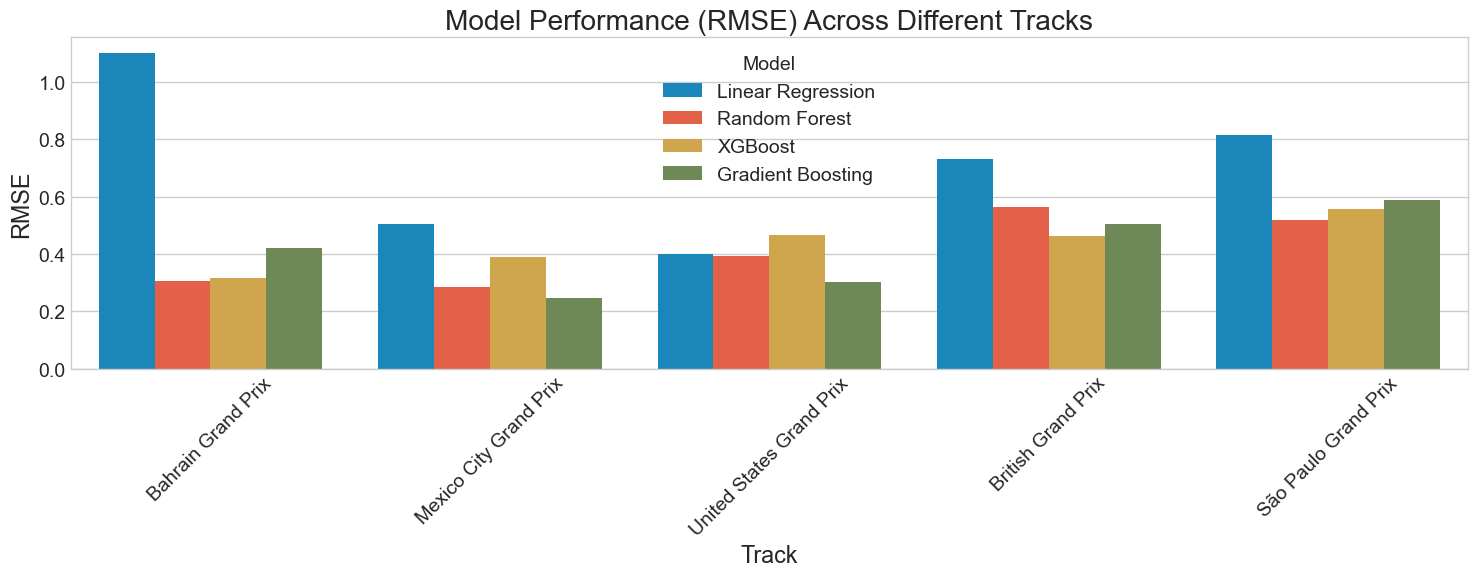

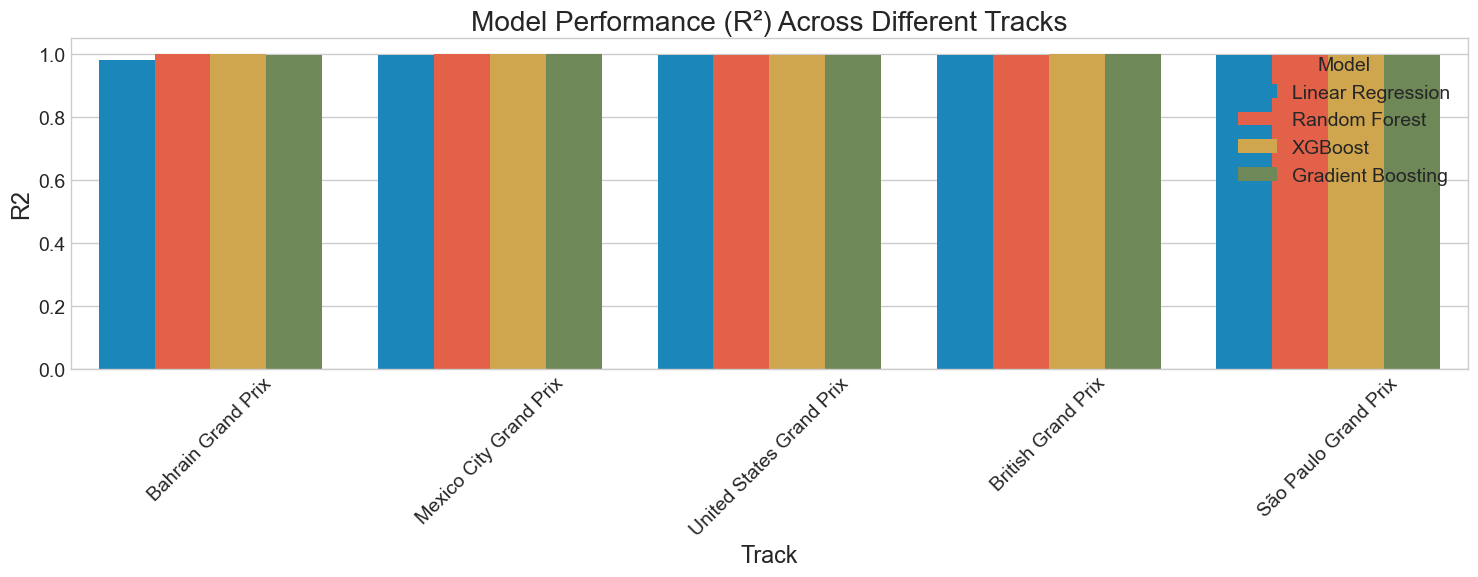

In [19]:
# Plot RMSE comparison across tracks
plot_rmse(track_results)

# Plot R2 comparison across tracks
plot_r2(track_results)